<a href="https://colab.research.google.com/github/brianfuentes/Transtorno-de-sue-o-/blob/main/analisis_transtorno_del_sue%C3%B1o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# importa el dataset desde kaggle usando kagglehub
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uom190346a_sleep_health_and_lifestyle_dataset_path = kagglehub.dataset_download('uom190346a/sleep-health-and-lifestyle-dataset')#importamos nuestros datos desde kaggle

print('Data source import complete.')


100%|██████████| 2.54k/2.54k [00:00<00:00, 3.08MB/s]

Extracting files...
Data source import complete.


In [18]:
# En esta celda se importan las bibliotecas básicas para procesamiento de datos (numpy, pandas) y se listan los archivos disponibles en el entorno.
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv


# Importing Libraries

In [19]:
# Se cargan herramientas de preprocesamiento de sklearn, como codificadores y escaladores; también se importan métodos de validación y métricas. Además, se importa SMOTE para balancear clases y modelos como regresión logística y XGBoost.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Esta celda carga el archivo CSV con los datos del sueño en un DataFrame de pandas.
from sklearn.preprocessing import OneHotEncoder,LabelEncoder ,RobustScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


# Reading CSV data

In [21]:
#llamamos a nuestra tabla
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# EDA

In [22]:
#Visualizamos la tabla en este caso se puso de visualizar 5 columnas
df.head(5)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [23]:
#Vemos cuantos filas y columnas hay
df.shape

(374, 13)

In [24]:
#tipo de datos de cada columna
df.dtypes

,0
Person ID,int64
Gender,object
Age,int64
Occupation,object
Sleep Duration,float64
Quality of Sleep,int64
Physical Activity Level,int64
Stress Level,int64
BMI Category,object
Blood Pressure,object


In [25]:
#dscribe nos da el media meidana maximo, etc
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [26]:
#hacemos una variable que use todos los datos excepto person ID
columns = [column for column in df.columns if column!='Person ID']#hacemos una variable que use todos los datos excepto person ID

In [27]:
#imprime los valores unicos junto con el nombre de la columna
for column in columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Gender': ['Male' 'Female']
Unique values in 'Age': [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52
 53 54 55 56 57 58 59]
Unique values in 'Occupation': ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
Unique values in 'Sleep Duration': [6.1 6.2 5.9 6.3 7.8 6.  6.5 7.6 7.7 7.9 6.4 7.5 7.2 5.8 6.7 7.3 7.4 7.1
 6.6 6.9 8.  6.8 8.1 8.3 8.5 8.4 8.2]
Unique values in 'Quality of Sleep': [6 4 7 5 8 9]
Unique values in 'Physical Activity Level': [42 60 30 40 75 35 45 50 32 70 80 55 90 47 65 85]
Unique values in 'Stress Level': [6 8 7 4 3 5]
Unique values in 'BMI Category': ['Overweight' 'Normal' 'Obese' 'Normal Weight']
Unique values in 'Blood Pressure': ['126/83' '125/80' '140/90' '120/80' '132/87' '130/86' '117/76' '118/76'
 '128/85' '131/86' '128/84' '115/75' '135/88' '129/84' '130/85' '115/78'
 '119/77' '121/79' '125/82' '135/90' '122/80' '142/92' '140/95

In [28]:
# Replace NaN in 'Sleep Disorder' with 'No Disorder'
#Reemplaza los valores nulos
df['Sleep Disorder'].fillna('No Disorder', inplace=True)


In [29]:
# Cuenta cuántas personas hay en cada categoría de la columna 'Sleep Disorder' del dataset.
sleep_disorder_counts = df['Sleep Disorder'].value_counts()

print("Value counts of 'Sleep Disorder':")
print(sleep_disorder_counts)

Value counts of 'Sleep Disorder':
Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


In [30]:
#Primero, reemplaza el valor 'Normal' por 'Normal Weight' en la columna 'BMI Category'
#Luego, cuenta cuántas personas hay en cada categoría de índice de masa corporal (IMC)
df['BMI Category']=df['BMI Category'].replace({'Normal':'Normal Weight'})
df['BMI Category'].value_counts()

,count
BMI Category,
Normal Weight,216
Overweight,148
Obese,10


In [31]:
# bmi_counts = df['BMI Category'].value_counts()
#Crea un gráfico de barras que muestra cuántas personas hay en cada categoría de IMC
fig = px.histogram(data_frame=df, x = 'BMI Category', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()


- Obese suffer from Insomnia and Sleep Apnea
- Very few overweighted people have no sleep disorder
- Very few people of normal weight face sleep disorder

In [32]:
# Genera un gráfico de barras que muestra cómo se distribuye la calidad del sueño
fig = px.histogram(data_frame=df, x = 'Quality of Sleep', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()

In [33]:
#Crea un gráfico de barras donde se muestra la cantidad de personas por tipo de ocupación ('Occupation') y se divide por tipo de trastorno del sueño ('Sleep Disorder')
fig = px.histogram(data_frame=df, x = 'Occupation', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()

Occupation of Nurse,Teacher, Sales person and sales representative are prone to sleep disorder

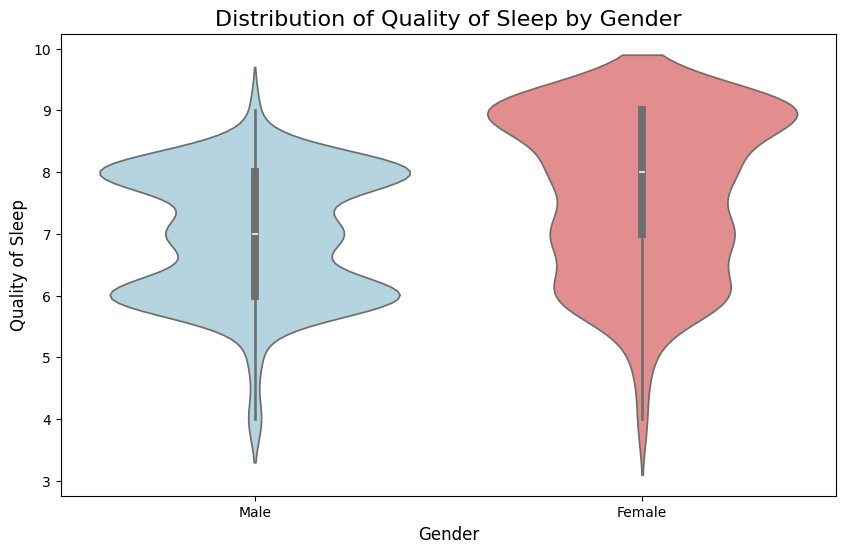

In [34]:
# Genera un gráfico de violín que muestra cómo varía la calidad del sueño ('Quality of Sleep') entre hombres y mujeres.
color_palette = {'Male': 'lightblue', 'Female': 'lightcoral'}
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Quality of Sleep', data=df, palette=color_palette)
plt.title('Distribution of Quality of Sleep by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Quality of Sleep', fontsize=12)
plt.show()

In [35]:
#Crea un gráfico de barras con plotly.express para mostrar la relación entre el nivel de estrés ('Stress Level') y la calidad del sueño ('Quality of Sleep'). Cada barra representa un nivel de estrés y su altura indica el valor de calidad del sueño correspondiente.
fig = px.bar(df,
             x='Stress Level',
             y='Quality of Sleep',
             color='Stress Level',
             title='Relationship between Stress Level and Quality of Sleep'
            )
fig.show()
#Para mi este grafico será más representativo si se agrupan los datos antes

**Splitting Blood Pressure into two columns: Systolic and Diastolic**

In [36]:
# Separar la columna 'Blood Pressure' en dos nuevas columnas: 'Systolic' y 'Diastolic'
# La función .str.split('/', expand=True) divide los valores por el '/' y los coloca en columnas separadas
# Luego, se usa pd.concat para unir estas nuevas columnas al DataFrame original
df = pd.concat([df, df['Blood Pressure'].str.split('/', expand=True)], axis=1).drop('Blood Pressure', axis=1)

# Renombra las nuevas columnas
df = df.rename(columns={0: 'Systolic', 1: 'Diastolic'})


In [37]:
# Convertir la columna 'Systolic' de tipo string (texto) a tipo float (número decimal) para poder trabajar con ellos
df['Systolic'] = df['Systolic'].astype(float)

# Convertir la columna 'Diastolic' de tipo string a tipo float por la misma razón
df['Diastolic'] = df['Diastolic'].astype(float)


In [38]:
# Creamos una lista llamada 'numeric_features' que contiene los nombres de las columnas numéricas del dataset.
numeric_features = ['Age', 'Sleep Duration',
                    'Physical Activity Level',
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

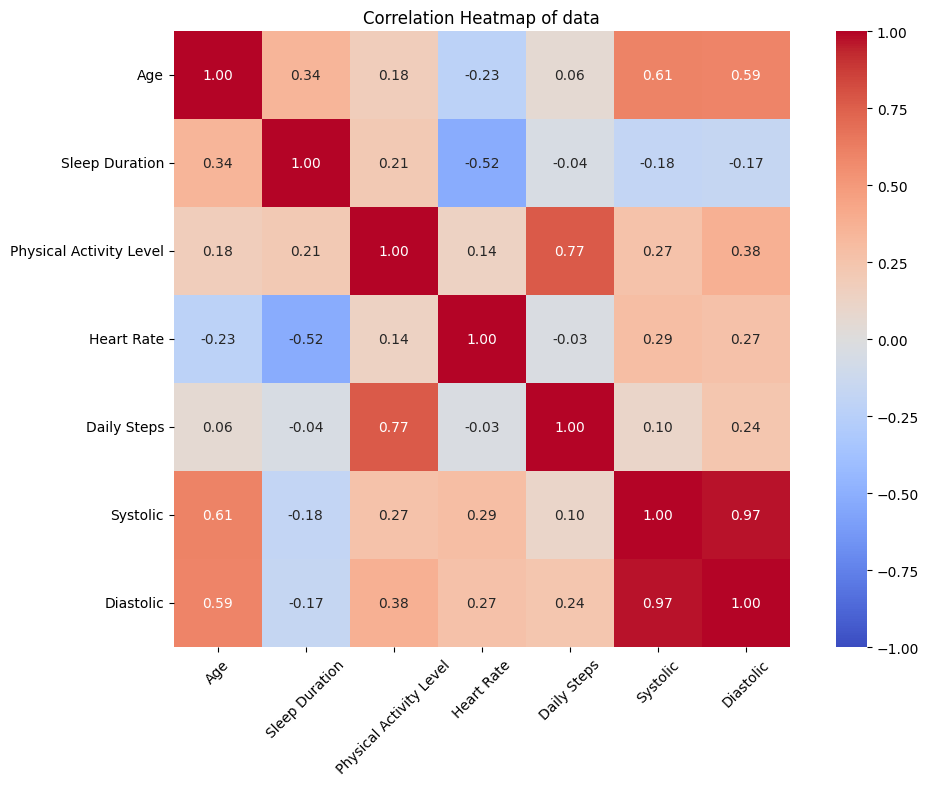

In [39]:
# Calcular la matriz de correlación entre las variables numéricas
corr_matrix = df[numeric_features].corr()

# Establecer el tamaño de la figura para que el gráfico sea más legible
plt.figure(figsize=(12, 8))

# Dibuja el mapa de calor  de la matriz de correlación
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, square=True)

# Personalizar etiquetas y título del gráfico
plt.title('Correlation Heatmap of data')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



In [40]:
# Eliminamos la columna 'Person ID' del DataFrame,ya que no nos es de utilidad
df.drop(columns=['Person ID'],inplace = True)

In [41]:
# Codificamos la variable categórica 'Sleep Disorder' como valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
df['Sleep Disorder'] = label_encoder.fit_transform(df['Sleep Disorder'])

In [42]:
# Imprimimos las clases originales antes de ser transformadas por LabelEncoder
print(label_encoder.classes_)

['Insomnia' 'No Disorder' 'Sleep Apnea']


# Preprocessing

In [43]:
#Aqui solo creamos nuevas litas
numeric_features = ['Age', 'Sleep Duration',
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

categorical_features = ['Occupation','Quality of Sleep','Gender',
                    'Physical Activity Level', 'Stress Level', 'BMI Category']

In [44]:
# Creamos un transformador de columnas (ColumnTransformer) para aplicar diferentes preprocesamientos a diferentes tipos de variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),#Aplicamos RobustScaler a las variables numéricas para reducir la influencia de valores atípicos
        ('cat', OneHotEncoder(drop='first',sparse_output =False, handle_unknown='ignore'), categorical_features)
        # Aplicamos OneHotEncoder a las variables categóricas
        # drop='first' elimina la primera categoría para evitar multicolinealidad
        # sparse_output=False devuelve un DataFrame en lugar de una matriz dispersa
        # handle_unknown='ignore' evita errores si aparecen nuevas categorías en los datos de prueba
    ])

In [45]:
# Separamos las variables predictoras (X) de la variable objetivo (y)
X = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

In [46]:
# Aplicamos el preprocesamiento definido anteriormente al conjunto de datos X
X_preprocessed = preprocessor.fit_transform(X)

# Handling Imbalance Data - SMOTE

In [47]:
# Initialize SMOTE
# Inicializamos SMOTE (Synthetic Minority Over-sampling Technique)
# Por lo que investigue esta técnica genera nuevas muestras sintéticas de la clase menor para balancear el dataset
smote = SMOTE(random_state=42)

# Esto crea un nuevo conjunto de datos con clases balanceadas
X_smote, y_smote = smote.fit_resample(X_preprocessed, y)
X_smote.shape

(657, 44)

In [48]:
# El 75% se usará para entrenar el modelo y el 25% para evaluarlo
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)

# Model Training

> Logistic Regression

Accuracy: 0.9090909090909091
Precision: 0.910767756617559
Recall: 0.9090909090909091
F1-score: 0.9084234273263183
              precision    recall  f1-score   support

           0       0.94      0.82      0.87        38
           1       0.88      0.95      0.92        64
           2       0.92      0.92      0.92        63

    accuracy                           0.91       165
   macro avg       0.91      0.90      0.90       165
weighted avg       0.91      0.91      0.91       165

Confusion Matrix:
[[31  3  4]
 [ 2 61  1]
 [ 0  5 58]]


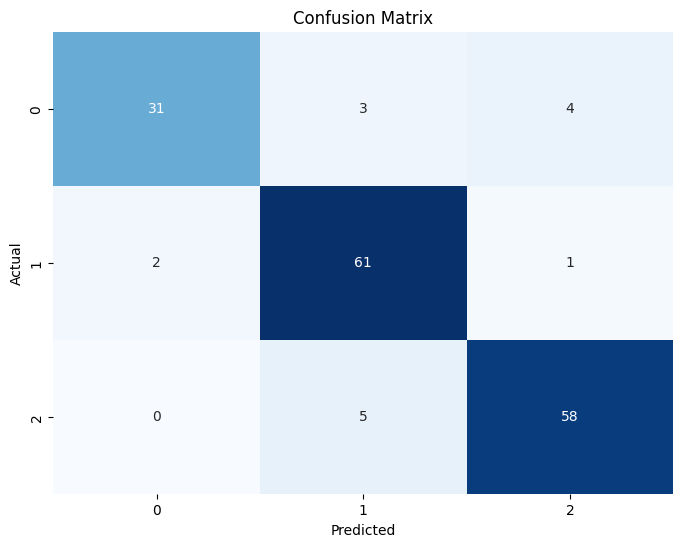

In [49]:
# Inicializamos el clasificador de Regresión Logística
model_lr = LogisticRegression()

# Entrenamos el modelo con los datos de entrenamiento
model_lr.fit(X_train, y_train)

# Realizamos predicciones sobre los datos de prueba
y_pred_lr = model_lr.predict(X_test)

# Calculamos las métricas de evaluación del modelo
# Accuracy: proporción de predicciones correctas
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Precision: qué tan precisas son las predicciones positivas (promedio ponderado)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')

# Recall: qué tan bien se detectan las clases positivas (promedio ponderado)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')

# F1-score: media armónica entre precisión y recall
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Imprimimos las métricas de evaluación
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1-score: {f1_lr}')

# Mostramos el informe completo con métricas por clase
print(classification_report(y_test, y_pred_lr))

# Calculamos la matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix:')
print(cm_lr)

# Graficamos la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



> XGB Classifier

Accuracy: 0.9272727272727272
Precision: 0.9287307861220904
Recall: 0.9272727272727272
F1-score: 0.9271254483064495
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        38
           1       0.90      0.97      0.93        64
           2       0.97      0.92      0.94        63

    accuracy                           0.93       165
   macro avg       0.93      0.92      0.92       165
weighted avg       0.93      0.93      0.93       165

Confusion Matrix:
[[33  3  2]
 [ 2 62  0]
 [ 1  4 58]]


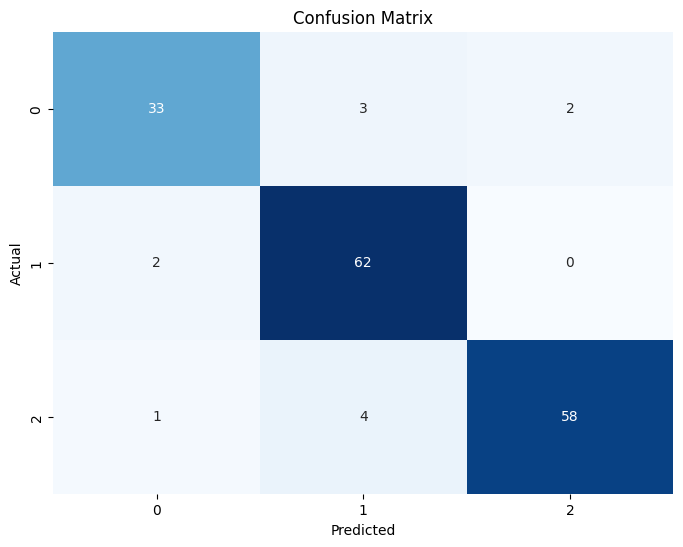

In [50]:
# Inicializamos el clasificador XGBoost (modelo de ensamble basado en árboles)
# Es muy potente para tareas de clasificación multiclase
model_xgb = xgb.XGBClassifier()

# Entrenamos el modelo con los datos de entrenamiento
model_xgb.fit(X_train, y_train)

# Realizamos predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test)

# Calculamos las métricas de evaluación del modelo
# Accuracy: proporción de predicciones correctas
accuracy_xgb = accuracy_score(y_test, y_pred)

# Precision: qué tan precisas son las predicciones positivas (ponderado por clase)
precision_xgb = precision_score(y_test, y_pred, average='weighted')

# Recall: qué tan bien se detectan las clases positivas
recall_xgb = recall_score(y_test, y_pred, average='weighted')

# F1-score: media armónica entre precisión y recall
f1_xgb = f1_score(y_test, y_pred, average='weighted')

# Imprimimos las métricas
print(f'Accuracy: {accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall: {recall_xgb}')
print(f'F1-score: {f1_xgb}')

# Generamos un informe detallado por clase
print(classification_report(y_test, y_pred))

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Graficamos la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


> Cross Eval XGB Model

In [51]:
# Inicializamos el modelo XGBoost con configuración específica
# random_state asegura reproducibilidad
# use_label_encoder=False evita advertencias con versiones recientes de XGBoost
# eval_metric='mlogloss' define la métrica de evaluación interna del modelo (log loss multiclase)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Definimos la estrategia de validación cruzada estratificada
# Esto asegura que cada pliegue mantenga la misma proporción de clases que el conjunto original
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ejecutamos validación cruzada usando la métrica de precisión (accuracy)
# cross_val_score entrena el modelo 5 veces (según los pliegues) y devuelve la precisión de cada iteración
scores = cross_val_score(xgb_model, X_smote, y_smote, cv=cv, scoring='accuracy')


In [52]:
scores

array([0.92424242, 0.89393939, 0.93129771, 0.9389313 , 0.92366412])

> Gradient Boosting Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        38
           1       0.90      0.97      0.93        64
           2       0.95      0.90      0.93        63

    accuracy                           0.92       165
   macro avg       0.91      0.91      0.91       165
weighted avg       0.92      0.92      0.91       165



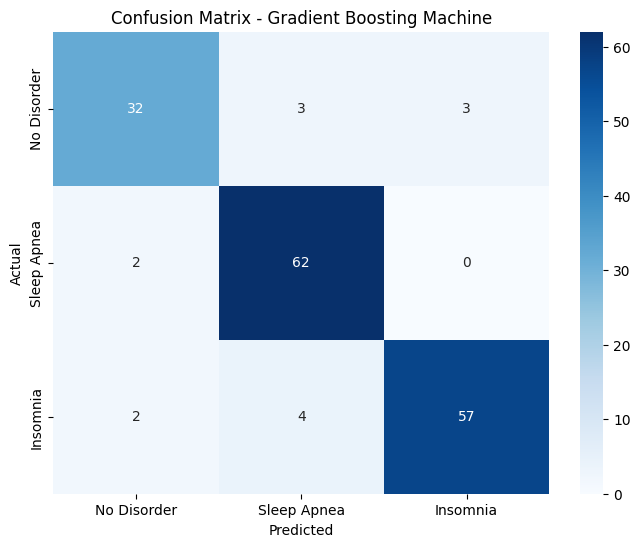

Accuracy: 0.9152
Precision: 0.9160
Recall: 0.9152
F1 Score: 0.9147


In [53]:
# Importamos el clasificador Gradient Boosting de sklearn
from sklearn.ensemble import GradientBoostingClassifier

# Inicializamos el modelo Gradient Boosting con una semilla fija para reproducibilidad
gbm_clf = GradientBoostingClassifier(random_state=42)

# Entrenamos el modelo usando los datos de entrenamiento
gbm_clf.fit(X_train, y_train)

# Realizamos predicciones con los datos de prueba
y_pred = gbm_clf.predict(X_test)

# Calculamos las métricas de rendimiento del modelo
accuracy_gbm = accuracy_score(y_test, y_pred)  # Precisión global
precision_gbm = precision_score(y_test, y_pred, average='weighted')  # Precisión ponderada
recall_gbm = recall_score(y_test, y_pred, average='weighted')  # Sensibilidad/Recall ponderado
f1_gbm = f1_score(y_test, y_pred, average='weighted')  # F1 Score ponderado

# Mostramos el reporte de clasificación con métricas por clase
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión como mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'],
            yticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting Machine')
plt.show()

# Imprimimos las métricas redondeadas a 4 decimales
print(f"Accuracy: {accuracy_gbm:.4f}")
print(f"Precision: {precision_gbm:.4f}")
print(f"Recall: {recall_gbm:.4f}")
print(f"F1 Score: {f1_gbm:.4f}")


> K Neighbors Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        38
           1       0.91      0.91      0.91        64
           2       0.97      0.92      0.94        63

    accuracy                           0.91       165
   macro avg       0.90      0.91      0.90       165
weighted avg       0.91      0.91      0.91       165



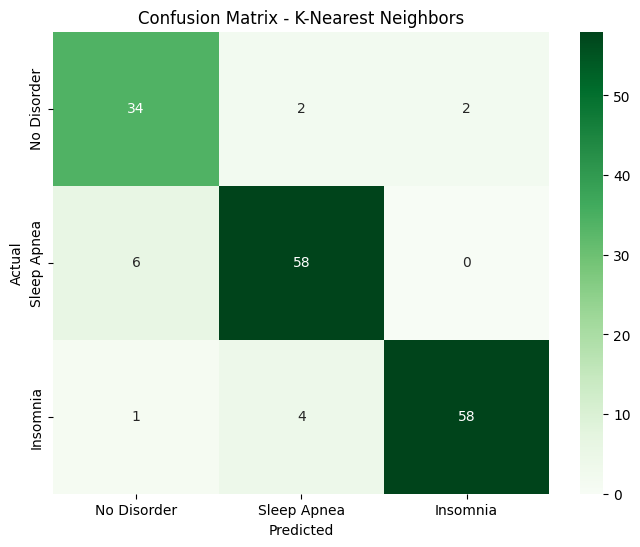

Accuracy: 0.9091
Precision: 0.9116
Recall: 0.9091
F1 Score: 0.9098


In [54]:
# Importamos el clasificador K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

# Inicializamos el clasificador KNN con k=5 (número de vecinos a considerar)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Entrenamos el modelo con los datos de entrenamiento
knn_clf.fit(X_train, y_train)

# Hacemos predicciones sobre los datos de prueba
y_pred = knn_clf.predict(X_test)

# Calculamos las métricas de evaluación del modelo
accuracy_knn = accuracy_score(y_test, y_pred)              # Precisión global
precision_knn = precision_score(y_test, y_pred, average='weighted')  # Precisión ponderada
recall_knn = recall_score(y_test, y_pred, average='weighted')        # Recall ponderado
f1_knn = f1_score(y_test, y_pred, average='weighted')                # F1-score ponderado

# Mostramos el reporte de clasificación con métricas por clase
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d',
            xticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'],
            yticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()

# Imprimimos las métricas finales del modelo
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")


# Model Comparison

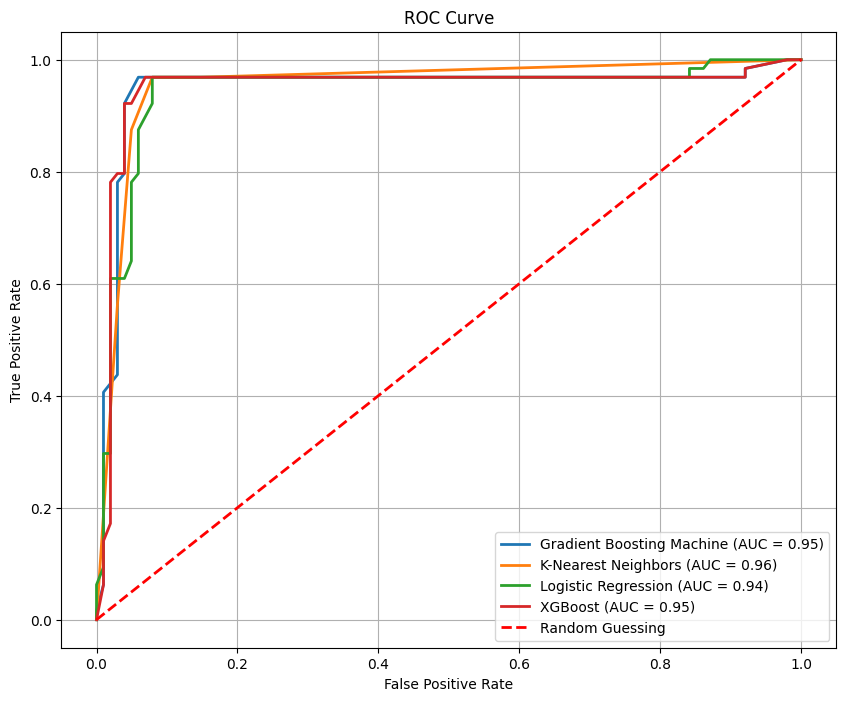

In [59]:
 # Importamos las funciones necesarias para generar la curva ROC y calcular el AUC
from sklearn.metrics import roc_curve, auc

# Inicializamos una figura de tamaño grande para graficar todas las curvas ROC
fig_roc = plt.figure(figsize=(10, 8))

# Lista con los nombres de los modelos que vamos a graficar
models = ['Gradient Boosting Machine', 'K-Nearest Neighbors', 'Logistic Regression', 'XGBoost']

# Iteramos sobre los modelos para calcular y graficar su curva ROC
for idx, model in enumerate([gbm_clf, knn_clf, model_lr, model_xgb]):
    # Obtenemos las probabilidades de predicción para la clase 1
    # En KNN se usa la matriz completa de predict_proba y se selecciona la columna correspondiente
    if model == knn_clf:
        y_scores = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)

    # Calculamos el área bajo la curva (AUC)
    roc_auc = auc(fpr, tpr)

    # Graficamos la curva ROC del modelo con su AUC en la leyenda
    plt.plot(fpr, tpr, lw=2, label=f'{models[idx]} (AUC = {roc_auc:.2f})')

# Agregamos la curva diagonal de referencia (adivinanza aleatoria)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')

# Etiquetas y título del gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# Mostramos el gráfico
plt.show()


# Saving Model

In [56]:
# Importamos la biblioteca pickle para guardar modelos entrenados
import pickle
with open("Model_Prediction.sav", "wb") as f:
    pickle.dump(model_xgb,f)
# Guardamos (serializamos) el modelo de XGBoost en el archivo

In [57]:
#guarda el objeto de preprocesamiento (ColumnTransformer) en un archivo .sav
with open('preprocessor.sav', 'wb') as f:
    pickle.dump(preprocessor, f)

In [58]:


# # Load the saved model
# model_xgb = joblib.load('model_xgb.pkl')

# # Load label encoders for categorical variables
# label_encoder = LabelEncoder()

# # Function to handle user input
# def get_user_input():
#     # Example user input (you can modify this based on your actual input method)
#     user_data = {}

#     # Accepting user input dynamically
#     print("Please enter the following information:")

#     user_data['Gender'] = input("Gender (Male/Female): ").strip()
#     user_data['Age'] = int(input("Age: ").strip())
#     user_data['Occupation'] = input("Occupation: ").strip()
#     user_data['Sleep Duration'] = int(input("Sleep Duration (hours): ").strip())
#     user_data['Quality of Sleep'] = int(input("Quality of Sleep (1-10): ").strip())
#     user_data['Physical Activity Level'] = int(input("Physical Activity Level (minutes): ").strip())
#     user_data['Stress Level'] = int(input("Stress Level (1-10): ").strip())
#     user_data['BMI Category'] = input("BMI Category: ").strip()
#     user_data['Blood Pressure'] = input("Blood Pressure (Systolic/Diastolic): ").strip()
#     user_data['Heart Rate'] = int(input("Heart Rate (bpm): ").strip())
#     user_data['Daily Steps'] = int(input("Daily Steps: ").strip())

#     # Convert user input to DataFrame for consistency
#     user_df = pd.DataFrame([user_data])

#     # Apply label encoding to categorical columns
#     cat_cols=['Gender','Occupation','BMI Category']
#     for col in cat_cols:
#         user_df[col] = label_encoder.fit_transform(user_df[col])

#     # Split the 'Blood Pressure' column into two columns
#     user_df[['Systolic BP', 'Diastolic BP']] = user_df['Blood Pressure'].str.split('/', expand=True)

#     # Convert the new columns to numeric type
#     user_df[['Systolic BP', 'Diastolic BP']] = user_df[['Systolic BP', 'Diastolic BP']].apply(pd.to_numeric)

#     # Drop the original 'Blood Pressure' column
#     user_df = user_df.drop('Blood Pressure', axis=1)

#     return user_df

# # Get user input
# user_df = get_user_input()

# # Predict sleep disorder class
# predicted_class = model_xgb.predict(user_df)

# # Map numerical prediction back to original classes
# sleep_disorder_map = {0: 'No Disorder', 1: 'Sleep Apnea', 2: 'Insomnia'}
# predicted_class_label = sleep_disorder_map[predicted_class[0]]

# print(f"Predicted Sleep Disorder: {predicted_class_label}")


Este bloque de código es una interfaz básica en consola para recibir datos del usuario, procesarlos y predecir el tipo de trastorno del sueño usando un modelo previamente entrenado.

In [60]:
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Cargar el modelo y el preprocesador
with open('Model_Prediction.sav', 'rb') as f:
    model_xgb = pickle.load(f)

with open('preprocessor.sav', 'rb') as f:
    preprocessor = pickle.load(f)

label_encoder = LabelEncoder()

def get_user_input():
    user_data = {}

    print("Please enter the following information:")
    user_data['Gender'] = input("Gender (Male/Female): ").strip()
    user_data['Age'] = int(input("Age: ").strip())
    user_data['Occupation'] = input("Occupation: ").strip()
    user_data['Sleep Duration'] = int(input("Sleep Duration (hours): ").strip())
    user_data['Quality of Sleep'] = int(input("Quality of Sleep (1-10): ").strip())
    user_data['Physical Activity Level'] = int(input("Physical Activity Level (minutes): ").strip())
    user_data['Stress Level'] = int(input("Stress Level (1-10): ").strip())
    user_data['BMI Category'] = input("BMI Category: ").strip()
    user_data['Blood Pressure'] = input("Blood Pressure (Systolic/Diastolic): ").strip()
    user_data['Heart Rate'] = int(input("Heart Rate (bpm): ").strip())
    user_data['Daily Steps'] = int(input("Daily Steps: ").strip())

    user_df = pd.DataFrame([user_data])
    user_df[['Systolic', 'Diastolic']] = user_df['Blood Pressure'].str.split('/', expand=True)
    user_df[['Systolic', 'Diastolic']] = user_df[['Systolic', 'Diastolic']].apply(pd.to_numeric)
    user_df = user_df.drop('Blood Pressure', axis=1)

    return user_df

user_df = get_user_input()

X_user = preprocessor.transform(user_df)

predicted_class = model_xgb.predict(X_user)
sleep_disorder_map = {0: 'No Disorder', 1: 'Sleep Apnea', 2: 'Insomnia'}
predicted_class_label = sleep_disorder_map[predicted_class[0]]

print(f"Predicted Sleep Disorder: {predicted_class_label}")


Please enter the following information:
Gender (Male/Female): male
Age: 22
Occupation: study
Sleep Duration (hours): 7
Quality of Sleep (1-10): 8
Physical Activity Level (minutes): 50
Stress Level (1-10): 6
BMI Category: normal
Blood Pressure (Systolic/Diastolic): 120/80
Heart Rate (bpm): 83
Daily Steps: 10000
Predicted Sleep Disorder: Sleep Apnea


# **Mejoras modelo**

Esta mejora se enfoca en interpretar el modelo XGBoost observando qué variables tuvieron más impacto en sus predicciones. Esto es crucial cuando se quiere entender qué factores influyen más en los trastornos del sueño, más allá de simplemente obtener un buen rendimiento predictivo.

XGBoost permite acceder a la importancia de cada variable a través del atributo .feature_importances_, que indica cuánto contribuyó cada variable a la predicción general del modelo (en promedio, a través de todos los árboles del modelo).



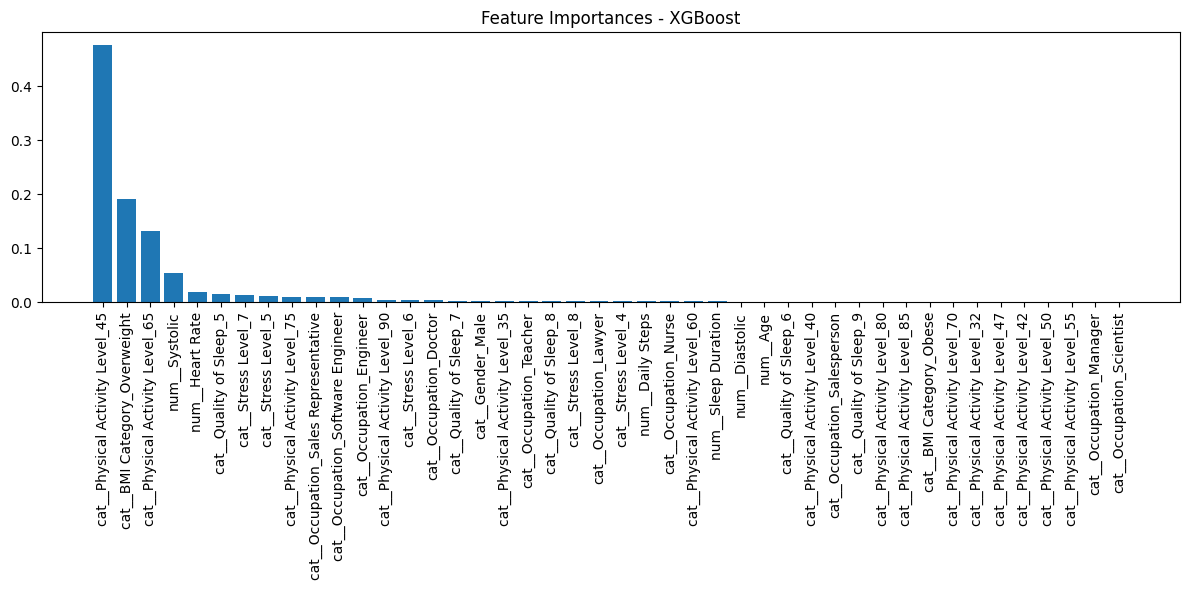

In [65]:
# Obtenemos la importancia de cada variable desde el modelo XGBoost
importancias = model_xgb.feature_importances_

# Obtenemos los nombres de las variables transformadas por el preprocesador
nombres_variables = preprocessor.get_feature_names_out()

# Ordenamos los índices de las variables según su importancia (de mayor a menor)
indices_ordenados = np.argsort(importancias)[::-1]

# Configuramos el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Graficamos un gráfico de barras con las importancias ordenadas
plt.bar(range(len(importancias)), importancias[indices_ordenados], tick_label=nombres_variables[indices_ordenados])

# Rotamos las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=90)

# Agregamos título y mejoramos el ajuste visual
plt.title("Importancia de Variables - XGBoost")
plt.tight_layout()

# Mostramos el gráfico
plt.show()


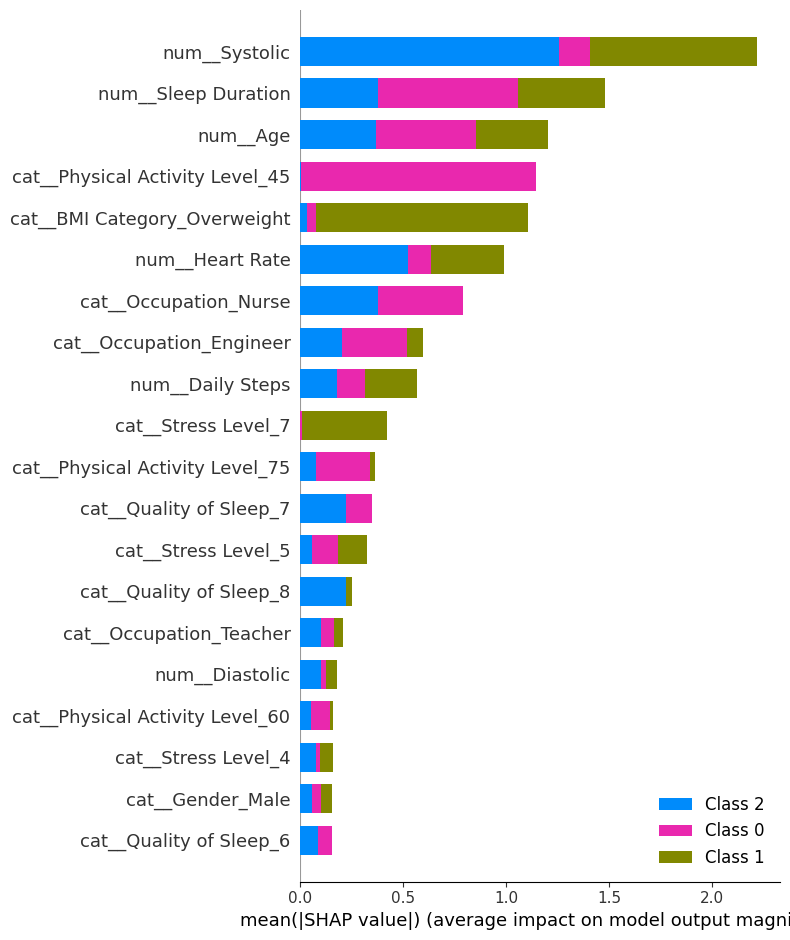

In [72]:
# Creamos un explicador SHAP basado en el modelo XGBoost entrenado
explicador = shap.Explainer(model_xgb)

# Calculamos los valores SHAP para el conjunto de prueba
# Cada valor SHAP representa cuánto contribuye cada variable a la predicción
valores_shap = explicador(X_test)

# Mostramos un gráfico resumen de los valores SHAP
# El gráfico muestra: importancia, dirección del efecto y distribución de cada variable
shap.summary_plot(valores_shap, X_test, feature_names=preprocessor.get_feature_names_out())



vemos que valores altos de Stress Level empujan la predicción hacia "trastorno".

Este bloque realiza una validación cruzada comparativa de varios modelos utilizando la métrica de F1 ponderado. Aquí te dejo la explicación detallada y el código traducido con nombres de variables en español y comentarios para que sea más claro:

 ¿Qué hace esta mejora?

Compara objetivamente el desempeño de distintos modelos (Regresión Logística, XGBoost, Gradient Boosting y KNN).

-utiliza validación cruzada estratificada con 5 particiones, manteniendo la proporción de clases.

-evalúa cada modelo con la métrica F1 ponderado, que es ideal para datos desbalanceados.

-reporta el promedio y la desviación estándar del F1, lo que da una idea de estabilidad y desempeño.



In [74]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Diccionario con los modelos a comparar
modelos = {
    "Regresión Logística": model_lr,
    "XGBoost": model_xgb,
    "Gradient Boosting": gbm_clf,
    "KNN": knn_clf
}

# Definimos una validación cruzada estratificada con 5 particiones
# shuffle=True mezcla los datos para mayor aleatoriedad
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iteramos sobre cada modelo y realizamos validación cruzada
for nombre, modelo in modelos.items():
    # Calculamos el puntaje F1 ponderado en cada partición
    puntajes = cross_val_score(modelo, X_smote, y_smote, cv=cv, scoring='f1_weighted')

    # Imprimimos el promedio y la desviación estándar del F1
    print(f"{nombre}: F1 promedio = {puntajes.mean():.4f} ± {puntajes.std():.4f}")


Regresión Logística: F1 promedio = 0.9024 ± 0.0090
XGBoost: F1 promedio = 0.9223 ± 0.0154
Gradient Boosting: F1 promedio = 0.9130 ± 0.0142
KNN: F1 promedio = 0.9038 ± 0.0037


este bloque aplica Análisis de Componentes Principales (PCA) para reducir los datos a dos dimensiones y visualizar los grupos presentes en el conjunto balanceado.

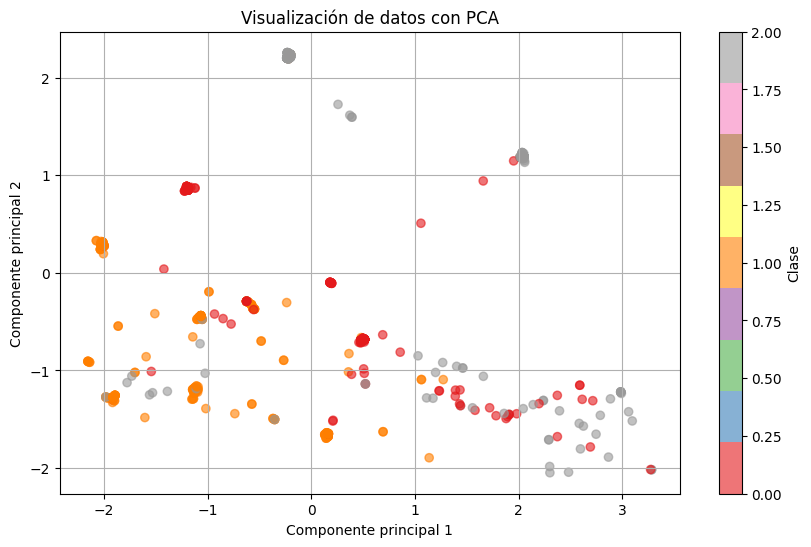

In [75]:
from sklearn.decomposition import PCA

# Aplicamos PCA para reducir los datos a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_smote)

# Graficamos los datos proyectados en los dos primeros componentes principales
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_smote, cmap='Set1', alpha=0.6)

# Títulos y etiquetas de los ejes
plt.title("Visualización de datos con PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")

# Agregamos una barra de colores para identificar las clases
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()


 utilizamos Isolation Forest, una técnica de detección de anomalías, para identificar outliers en el conjunto de datos balanceado.

 Nos permite identificar registros anómalos que podrían distorsionar el entrenamiento.

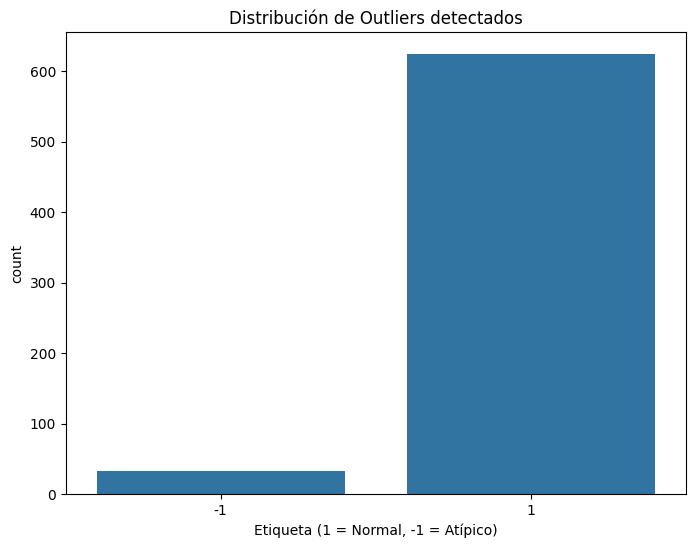

In [78]:
from sklearn.ensemble import IsolationForest

# Inicializamos el modelo Isolation Forest para detectar valores atípicos
# contamination indica qué proporción de los datos esperamos que sean outliers (~5%)
iso = IsolationForest(contamination=0.05, random_state=42)

# Entrenamos el modelo sobre los datos y obtenemos predicciones
# Los valores predichos son 1 (normal) o -1 (outlier)
outliers = iso.fit_predict(X_smote)

# Visualizamos la cantidad de outliers detectados
plt.figure(figsize=(8, 6))
sns.countplot(x=outliers)
plt.title("Distribución de Outliers detectados")
plt.xlabel("Etiqueta (1 = Normal, -1 = Atípico)")
plt.show()



comparamos el desempeño de los modelos entrenados para predecir trastornos del sueño, utilizando métricas como accuracy, F1 ponderado y validación cruzada.


In [79]:
# Diccionario con modelos
modelos = {
    "Regresión Logística": model_lr,
    "XGBoost": model_xgb,
    "Gradient Boosting": gbm_clf,
    "KNN": knn_clf
}

# Evaluar métricas en conjunto de prueba
resultados = []

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    resultados.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    })

df_resultados = pd.DataFrame(resultados).set_index("Modelo")
display(df_resultados)


,Accuracy,F1 Score,Precision,Recall
Modelo,,,,
Regresión Logística,0.909091,0.908423,0.910768,0.909091
XGBoost,0.927273,0.927125,0.928731,0.927273
Gradient Boosting,0.915152,0.914693,0.915970,0.915152
KNN,0.909091,0.909839,0.911589,0.909091


In [80]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = {}

for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X_smote, y_smote, cv=cv, scoring='f1_weighted')
    f1_cv[nombre] = (scores.mean(), scores.std())

# Mostrar como tabla
df_cv = pd.DataFrame(f1_cv, index=["F1 Promedio", "Desviación Std"]).T
display(df_cv)


,F1 Promedio,Desviación Std
Regresión Logística,0.902397,0.009005
XGBoost,0.922267,0.015431
Gradient Boosting,0.913028,0.014161
KNN,0.903799,0.003680


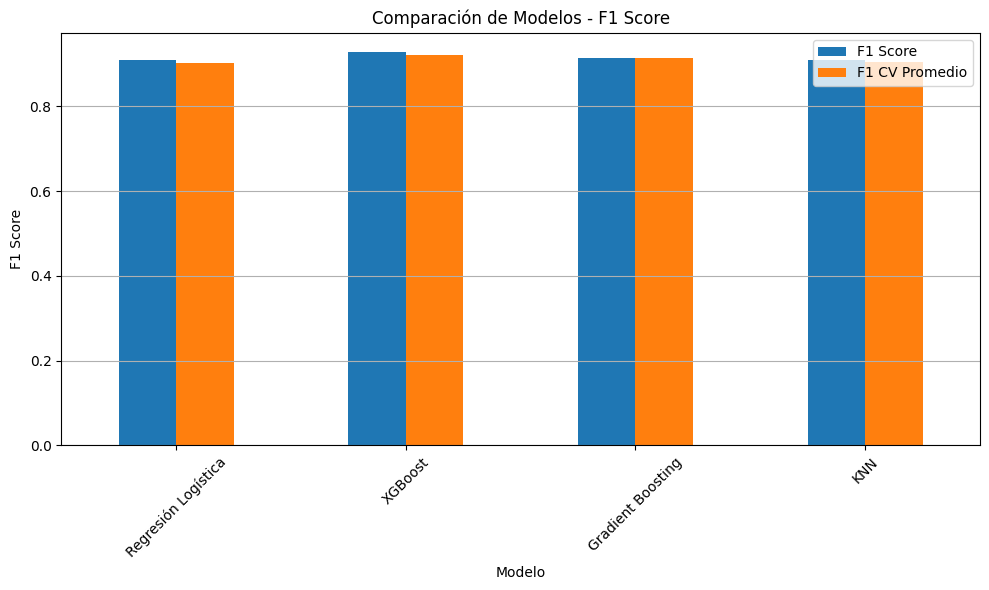

In [81]:
# Gráfico comparativo de F1 scores
df_resultados['F1 CV Promedio'] = df_cv['F1 Promedio']
df_resultados[['F1 Score', 'F1 CV Promedio']].plot(kind='bar', figsize=(10, 6))
plt.title("Comparación de Modelos - F1 Score")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


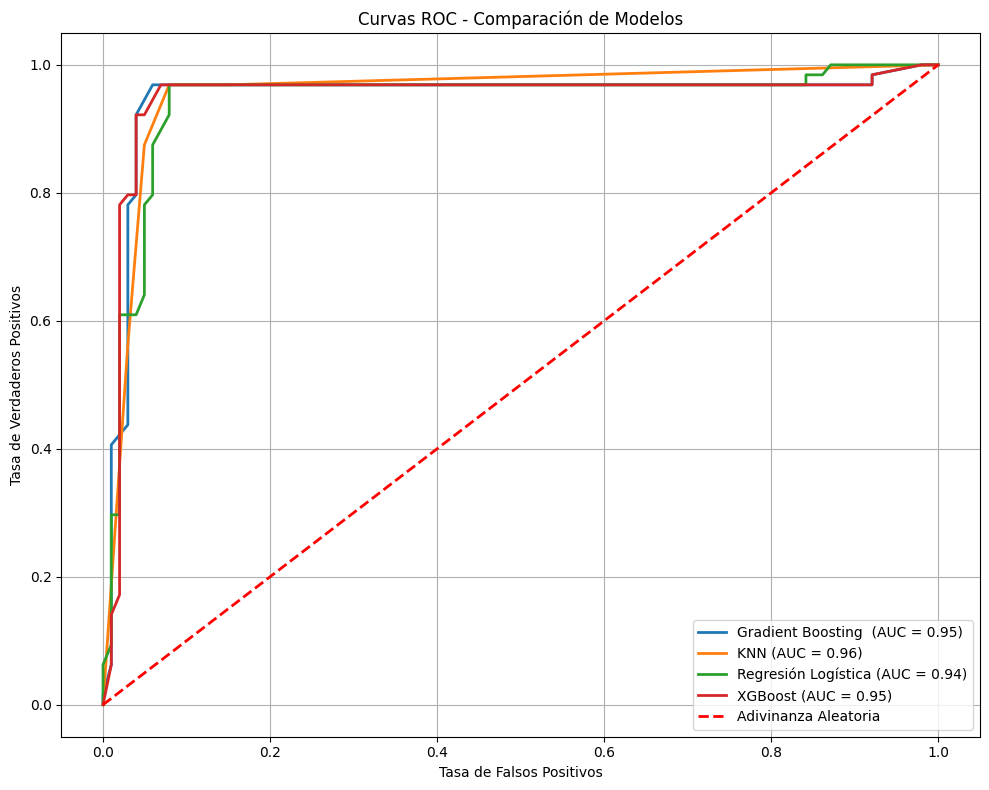

In [83]:
modelos = [gbm_clf, knn_clf, model_lr, model_xgb]
nombres_modelos = ['Gradient Boosting ', 'KNN', "Regresión Logística", 'XGBoost']

# Inicializamos la figura
plt.figure(figsize=(10, 8))

# Graficamos la curva ROC para cada modelo
for idx, modelo in enumerate(modelos):
    y_scores = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{nombres_modelos[idx]} (AUC = {roc_auc:.2f})')

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Adivinanza Aleatoria')

# Configuraciones del gráfico
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()